**STEP 1: Importing libraries and dataset**

In [3]:
# DataFrame
import pandas as pd

# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import f1_score, accuracy_score

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Word2Vec
import gensim
from gensim.models import Word2Vec

# Utility
import string
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools
import random
import datetime

# WordCloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter, defaultdict

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
!pip install chardet

# Import the chardet module
import chardet

In [6]:
with open('projectML.csv', 'rb') as f:
    encoding = chardet.detect(f.read())['encoding']
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('projectML.csv',encoding=encoding)

Saving projectML.csv to projectML (2).csv


In [7]:
df

,Sno.,Text,Sentiment,Timestamp,User,Platform
0,1,Enjoying a beautiful day at the park! ...,0,1/15/2023 12:30,User123,Twitter
1,2,Traffic was terrible this morning. ...,1,1/15/2023 8:45,CommuterX,Twitter
2,3,Just finished an amazing workout! üí™ ...,0,1/15/2023 15:45,FitnessFan,Instagram
3,4,Excited about the upcoming weekend getaway! ...,0,1/15/2023 18:20,AdventureX,Facebook
4,5,Trying out a new recipe for dinner tonight. ...,2,1/15/2023 19:55,ChefCook,Instagram
...,...,...,...,...,...,...
742,743,Drifting in the void of emptiness.,1,3/17/2023 19:30,EchoesRegret,Twitter
743,744,Shattered by the echoes of regret.,1,3/18/2023 19:30,DespairCycle,Instagram
744,745,Trapped in the cycle of despair.,1,3/19/2023 19:30,SoulDarkness,Facebook
745,746,Blinded by the darkness of the soul.,1,3/20/2023 19:30,SorrowSuffocation,Twitter


'0' represents positive sentiments

'1' represents negative sentiments

'2' represents neutral sentiments

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747 entries, 0 to 746
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sno.       747 non-null    int64 
 1   Text       747 non-null    object
 2   Sentiment  747 non-null    int64 
 3   Timestamp  747 non-null    object
 4   User       747 non-null    object
 5   Platform   747 non-null    object
dtypes: int64(2), object(4)
memory usage: 35.1+ KB


**STEP 2: Data Preprocessing**

Step 2.1: Variable Declaration

In [9]:
# Variables related to dataset
DATASET_COLUMNS = ["Text", "Sentiment"]
DATASET_ENCODING = "utf-8"
TRAIN_SIZE = 0.8

# Parameters for WORD2VEC
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# Parameters related to KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# Variable specific to SENTIMENT
POSITIVE = "0"
NEGATIVE = "1"
NEUTRAL = "2"
SENTIMENT_THRESHOLDS = (0.5, 0.8)

# Variables for Exporting purpose
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

# MISC
plt.style.use('fivethirtyeight')
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250

Variable Declaration, I am defining and initializing key variables and parameters that will be used throughout my sentiment analysis project because by defining these variables, I am organizing my project and making it easier to adjust parameters and configurations as needed.

Step 2.2: Null Values Identification and Treatment

In [10]:
# Confirming presence of missing values in each variable
df.isnull().sum()

Sno.         0
Text         0
Sentiment    0
Timestamp    0
User         0
Platform     0
dtype: int64

no missing values in any of the columns of dataset

Step 2.3: Label Encoding

In [11]:
decode_map = {0: "POSITIVE", 1: "NEGATIVE", 2: "NEUTRAL"}

def decode_sentiment(label):
    return decode_map[label]

df['Sentiment_decoded'] = df['Sentiment'].apply(lambda x: decode_sentiment(x))

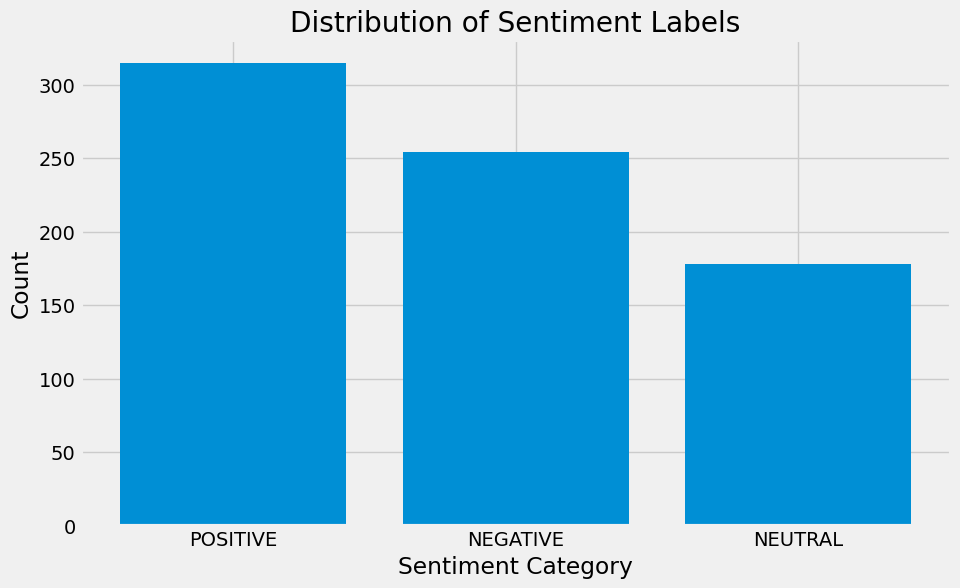

In [12]:
from collections import Counter

sentiment_counts = Counter(df['Sentiment_decoded'])

plt.figure(figsize=(10, 6))
plt.bar(sentiment_counts.keys(), sentiment_counts.values())
plt.title("Distribution of Sentiment Labels")
plt.xlabel("Sentiment Category")
plt.ylabel("Count")
plt.show()

The number of Positive Sentiments in the dataset are: 315

The number of Negative Sentiments in the dataset are: 254

The number of Neutral Sentiments in the dataset are: 178

Step 2.4: Text Manipulation and Structurization

In [13]:
stop_words = set(stopwords.words("english"))
stop_words.remove('not')
more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
stop_words = stop_words.union(more_stopwords)

stemmer = SnowballStemmer("english")

In [14]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_html(text):
    html = re.compile(r'<.*?>')
    return re.sub(html, '', text)

def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

def remove_quotes(text):
    quotes = re.compile(r'[^A-Za-z0-9\s]+')
    return re.sub(quotes, '', text)

# Applying helper functions
df['mod_text'] = df['Text'].apply(lambda x: remove_URL(x))
df['mod_text'] = df['mod_text'].apply(lambda x: remove_emoji(x))
df['mod_text'] = df['mod_text'].apply(lambda x: remove_html(x))
df['mod_text'] = df['mod_text'].apply(lambda x: remove_punct(x))
df['mod_text'] = df['mod_text'].apply(lambda x: remove_quotes(x))

df.head()

,Sno.,Text,Sentiment,Timestamp,User,Platform,Sentiment_decoded,mod_text
0,1,Enjoying a beautiful day at the park! ...,0,1/15/2023 12:30,User123,Twitter,POSITIVE,Enjoying a beautiful day at the park ...
1,2,Traffic was terrible this morning. ...,1,1/15/2023 8:45,CommuterX,Twitter,NEGATIVE,Traffic was terrible this morning ...
2,3,Just finished an amazing workout! üí™ ...,0,1/15/2023 15:45,FitnessFan,Instagram,POSITIVE,Just finished an amazing workout
3,4,Excited about the upcoming weekend getaway! ...,0,1/15/2023 18:20,AdventureX,Facebook,POSITIVE,Excited about the upcoming weekend getaway ...
4,5,Trying out a new recipe for dinner tonight. ...,2,1/15/2023 19:55,ChefCook,Instagram,NEUTRAL,Trying out a new recipe for dinner tonight ...


Removing URLs from text.

Removing emojis from text.

Removing HTML tags from text.

Removing punctuation from text.

Removing quotes from text.

In [15]:
# Tokenizing the text
df['tokenized'] = df['mod_text'].apply(word_tokenize)

df.head()

,Sno.,Text,Sentiment,Timestamp,User,Platform,Sentiment_decoded,mod_text,tokenized
0,1,Enjoying a beautiful day at the park! ...,0,1/15/2023 12:30,User123,Twitter,POSITIVE,Enjoying a beautiful day at the park ...,"[Enjoying, a, beautiful, day, at, the, park]"
1,2,Traffic was terrible this morning. ...,1,1/15/2023 8:45,CommuterX,Twitter,NEGATIVE,Traffic was terrible this morning ...,"[Traffic, was, terrible, this, morning]"
2,3,Just finished an amazing workout! üí™ ...,0,1/15/2023 15:45,FitnessFan,Instagram,POSITIVE,Just finished an amazing workout,"[Just, finished, an, amazing, workout]"
3,4,Excited about the upcoming weekend getaway! ...,0,1/15/2023 18:20,AdventureX,Facebook,POSITIVE,Excited about the upcoming weekend getaway ...,"[Excited, about, the, upcoming, weekend, getaway]"
4,5,Trying out a new recipe for dinner tonight. ...,2,1/15/2023 19:55,ChefCook,Instagram,NEUTRAL,Trying out a new recipe for dinner tonight ...,"[Trying, out, a, new, recipe, for, dinner, ton..."


In [16]:
# Lowercasing the tokenized text
df['lower'] = df['tokenized'].apply(lambda x: [word.lower() for word in x])

df.head()

,Sno.,Text,Sentiment,Timestamp,User,Platform,Sentiment_decoded,mod_text,tokenized,lower
0,1,Enjoying a beautiful day at the park! ...,0,1/15/2023 12:30,User123,Twitter,POSITIVE,Enjoying a beautiful day at the park ...,"[Enjoying, a, beautiful, day, at, the, park]","[enjoying, a, beautiful, day, at, the, park]"
1,2,Traffic was terrible this morning. ...,1,1/15/2023 8:45,CommuterX,Twitter,NEGATIVE,Traffic was terrible this morning ...,"[Traffic, was, terrible, this, morning]","[traffic, was, terrible, this, morning]"
2,3,Just finished an amazing workout! üí™ ...,0,1/15/2023 15:45,FitnessFan,Instagram,POSITIVE,Just finished an amazing workout,"[Just, finished, an, amazing, workout]","[just, finished, an, amazing, workout]"
3,4,Excited about the upcoming weekend getaway! ...,0,1/15/2023 18:20,AdventureX,Facebook,POSITIVE,Excited about the upcoming weekend getaway ...,"[Excited, about, the, upcoming, weekend, getaway]","[excited, about, the, upcoming, weekend, getaway]"
4,5,Trying out a new recipe for dinner tonight. ...,2,1/15/2023 19:55,ChefCook,Instagram,NEUTRAL,Trying out a new recipe for dinner tonight ...,"[Trying, out, a, new, recipe, for, dinner, ton...","[trying, out, a, new, recipe, for, dinner, ton..."


In [17]:
# Removing stopwords
df['stopwords_removed'] = df['lower'].apply(lambda x: [word for word in x if word not in stop_words])

df.head()

,Sno.,Text,Sentiment,Timestamp,User,Platform,Sentiment_decoded,mod_text,tokenized,lower,stopwords_removed
0,1,Enjoying a beautiful day at the park! ...,0,1/15/2023 12:30,User123,Twitter,POSITIVE,Enjoying a beautiful day at the park ...,"[Enjoying, a, beautiful, day, at, the, park]","[enjoying, a, beautiful, day, at, the, park]","[enjoying, beautiful, day, park]"
1,2,Traffic was terrible this morning. ...,1,1/15/2023 8:45,CommuterX,Twitter,NEGATIVE,Traffic was terrible this morning ...,"[Traffic, was, terrible, this, morning]","[traffic, was, terrible, this, morning]","[traffic, terrible, morning]"
2,3,Just finished an amazing workout! üí™ ...,0,1/15/2023 15:45,FitnessFan,Instagram,POSITIVE,Just finished an amazing workout,"[Just, finished, an, amazing, workout]","[just, finished, an, amazing, workout]","[finished, amazing, workout]"
3,4,Excited about the upcoming weekend getaway! ...,0,1/15/2023 18:20,AdventureX,Facebook,POSITIVE,Excited about the upcoming weekend getaway ...,"[Excited, about, the, upcoming, weekend, getaway]","[excited, about, the, upcoming, weekend, getaway]","[excited, upcoming, weekend, getaway]"
4,5,Trying out a new recipe for dinner tonight. ...,2,1/15/2023 19:55,ChefCook,Instagram,NEUTRAL,Trying out a new recipe for dinner tonight ...,"[Trying, out, a, new, recipe, for, dinner, ton...","[trying, out, a, new, recipe, for, dinner, ton...","[trying, new, recipe, dinner, tonight]"


In [18]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [19]:
# Applying part-of-speech (POS) tagging
df['pos_tags'] = df['stopwords_removed'].apply(nltk.tag.pos_tag)

df.head()

,Sno.,Text,Sentiment,Timestamp,User,Platform,Sentiment_decoded,mod_text,tokenized,lower,stopwords_removed,pos_tags
0,1,Enjoying a beautiful day at the park! ...,0,1/15/2023 12:30,User123,Twitter,POSITIVE,Enjoying a beautiful day at the park ...,"[Enjoying, a, beautiful, day, at, the, park]","[enjoying, a, beautiful, day, at, the, park]","[enjoying, beautiful, day, park]","[(enjoying, VBG), (beautiful, JJ), (day, NN), ..."
1,2,Traffic was terrible this morning. ...,1,1/15/2023 8:45,CommuterX,Twitter,NEGATIVE,Traffic was terrible this morning ...,"[Traffic, was, terrible, this, morning]","[traffic, was, terrible, this, morning]","[traffic, terrible, morning]","[(traffic, NN), (terrible, JJ), (morning, NN)]"
2,3,Just finished an amazing workout! üí™ ...,0,1/15/2023 15:45,FitnessFan,Instagram,POSITIVE,Just finished an amazing workout,"[Just, finished, an, amazing, workout]","[just, finished, an, amazing, workout]","[finished, amazing, workout]","[(finished, VBN), (amazing, VBG), (workout, NN)]"
3,4,Excited about the upcoming weekend getaway! ...,0,1/15/2023 18:20,AdventureX,Facebook,POSITIVE,Excited about the upcoming weekend getaway ...,"[Excited, about, the, upcoming, weekend, getaway]","[excited, about, the, upcoming, weekend, getaway]","[excited, upcoming, weekend, getaway]","[(excited, JJ), (upcoming, JJ), (weekend, NN),..."
4,5,Trying out a new recipe for dinner tonight. ...,2,1/15/2023 19:55,ChefCook,Instagram,NEUTRAL,Trying out a new recipe for dinner tonight ...,"[Trying, out, a, new, recipe, for, dinner, ton...","[trying, out, a, new, recipe, for, dinner, ton...","[trying, new, recipe, dinner, tonight]","[(trying, VBG), (new, JJ), (recipe, NN), (dinn..."


In [20]:
def get_wordnet_pos(tag):
    if tag.startswith('A'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Apply WordNet POS tagging
df['wordnet_pos'] = df['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

df.head()

,Sno.,Text,Sentiment,Timestamp,User,Platform,Sentiment_decoded,mod_text,tokenized,lower,stopwords_removed,pos_tags,wordnet_pos
0,1,Enjoying a beautiful day at the park! ...,0,1/15/2023 12:30,User123,Twitter,POSITIVE,Enjoying a beautiful day at the park ...,"[Enjoying, a, beautiful, day, at, the, park]","[enjoying, a, beautiful, day, at, the, park]","[enjoying, beautiful, day, park]","[(enjoying, VBG), (beautiful, JJ), (day, NN), ...","[(enjoying, v), (beautiful, n), (day, n), (par..."
1,2,Traffic was terrible this morning. ...,1,1/15/2023 8:45,CommuterX,Twitter,NEGATIVE,Traffic was terrible this morning ...,"[Traffic, was, terrible, this, morning]","[traffic, was, terrible, this, morning]","[traffic, terrible, morning]","[(traffic, NN), (terrible, JJ), (morning, NN)]","[(traffic, n), (terrible, n), (morning, n)]"
2,3,Just finished an amazing workout! üí™ ...,0,1/15/2023 15:45,FitnessFan,Instagram,POSITIVE,Just finished an amazing workout,"[Just, finished, an, amazing, workout]","[just, finished, an, amazing, workout]","[finished, amazing, workout]","[(finished, VBN), (amazing, VBG), (workout, NN)]","[(finished, v), (amazing, v), (workout, n)]"
3,4,Excited about the upcoming weekend getaway! ...,0,1/15/2023 18:20,AdventureX,Facebook,POSITIVE,Excited about the upcoming weekend getaway ...,"[Excited, about, the, upcoming, weekend, getaway]","[excited, about, the, upcoming, weekend, getaway]","[excited, upcoming, weekend, getaway]","[(excited, JJ), (upcoming, JJ), (weekend, NN),...","[(excited, n), (upcoming, n), (weekend, n), (g..."
4,5,Trying out a new recipe for dinner tonight. ...,2,1/15/2023 19:55,ChefCook,Instagram,NEUTRAL,Trying out a new recipe for dinner tonight ...,"[Trying, out, a, new, recipe, for, dinner, ton...","[trying, out, a, new, recipe, for, dinner, ton...","[trying, new, recipe, dinner, tonight]","[(trying, VBG), (new, JJ), (recipe, NN), (dinn...","[(trying, v), (new, n), (recipe, n), (dinner, ..."


This process helps in structuring and preparing text data by providing information about the grammatical roles of words, which can be useful for sentiment analysis and text classification.

In [21]:
# Applying word lemmatizer.
wnl = WordNetLemmatizer()

df['lemmatized'] = df['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
df['lemmatized'] = df['lemmatized'].apply(lambda x: [word for word in x if word not in stop_words])

df['lemma_str'] = [' '.join(map(str, l)) for l in df['lemmatized']]

df.head()

,Sno.,Text,Sentiment,Timestamp,User,Platform,Sentiment_decoded,mod_text,tokenized,lower,stopwords_removed,pos_tags,wordnet_pos,lemmatized,lemma_str
0,1,Enjoying a beautiful day at the park! ...,0,1/15/2023 12:30,User123,Twitter,POSITIVE,Enjoying a beautiful day at the park ...,"[Enjoying, a, beautiful, day, at, the, park]","[enjoying, a, beautiful, day, at, the, park]","[enjoying, beautiful, day, park]","[(enjoying, VBG), (beautiful, JJ), (day, NN), ...","[(enjoying, v), (beautiful, n), (day, n), (par...","[enjoy, beautiful, day, park]",enjoy beautiful day park
1,2,Traffic was terrible this morning. ...,1,1/15/2023 8:45,CommuterX,Twitter,NEGATIVE,Traffic was terrible this morning ...,"[Traffic, was, terrible, this, morning]","[traffic, was, terrible, this, morning]","[traffic, terrible, morning]","[(traffic, NN), (terrible, JJ), (morning, NN)]","[(traffic, n), (terrible, n), (morning, n)]","[traffic, terrible, morning]",traffic terrible morning
2,3,Just finished an amazing workout! üí™ ...,0,1/15/2023 15:45,FitnessFan,Instagram,POSITIVE,Just finished an amazing workout,"[Just, finished, an, amazing, workout]","[just, finished, an, amazing, workout]","[finished, amazing, workout]","[(finished, VBN), (amazing, VBG), (workout, NN)]","[(finished, v), (amazing, v), (workout, n)]","[finish, amaze, workout]",finish amaze workout
3,4,Excited about the upcoming weekend getaway! ...,0,1/15/2023 18:20,AdventureX,Facebook,POSITIVE,Excited about the upcoming weekend getaway ...,"[Excited, about, the, upcoming, weekend, getaway]","[excited, about, the, upcoming, weekend, getaway]","[excited, upcoming, weekend, getaway]","[(excited, JJ), (upcoming, JJ), (weekend, NN),...","[(excited, n), (upcoming, n), (weekend, n), (g...","[excited, upcoming, weekend, getaway]",excited upcoming weekend getaway
4,5,Trying out a new recipe for dinner tonight. ...,2,1/15/2023 19:55,ChefCook,Instagram,NEUTRAL,Trying out a new recipe for dinner tonight ...,"[Trying, out, a, new, recipe, for, dinner, ton...","[trying, out, a, new, recipe, for, dinner, ton...","[trying, new, recipe, dinner, tonight]","[(trying, VBG), (new, JJ), (recipe, NN), (dinn...","[(trying, v), (new, n), (recipe, n), (dinner, ...","[try, new, recipe, dinner, tonight]",try new recipe dinner tonight


This code applies word lemmatization using WordNet POS tags to the words in the 'wordnet_pos' column of DataFrame. It then removes stopwords from the lemmatized words and converts them back to a string format. The resulting lemmatized text is stored in a new column named 'lemma_str'.

In [22]:
print("Total Rows =", len(df.Text))

Total Rows = 747


In [23]:
df.head()

,Sno.,Text,Sentiment,Timestamp,User,Platform,Sentiment_decoded,mod_text,tokenized,lower,stopwords_removed,pos_tags,wordnet_pos,lemmatized,lemma_str
0,1,Enjoying a beautiful day at the park! ...,0,1/15/2023 12:30,User123,Twitter,POSITIVE,Enjoying a beautiful day at the park ...,"[Enjoying, a, beautiful, day, at, the, park]","[enjoying, a, beautiful, day, at, the, park]","[enjoying, beautiful, day, park]","[(enjoying, VBG), (beautiful, JJ), (day, NN), ...","[(enjoying, v), (beautiful, n), (day, n), (par...","[enjoy, beautiful, day, park]",enjoy beautiful day park
1,2,Traffic was terrible this morning. ...,1,1/15/2023 8:45,CommuterX,Twitter,NEGATIVE,Traffic was terrible this morning ...,"[Traffic, was, terrible, this, morning]","[traffic, was, terrible, this, morning]","[traffic, terrible, morning]","[(traffic, NN), (terrible, JJ), (morning, NN)]","[(traffic, n), (terrible, n), (morning, n)]","[traffic, terrible, morning]",traffic terrible morning
2,3,Just finished an amazing workout! üí™ ...,0,1/15/2023 15:45,FitnessFan,Instagram,POSITIVE,Just finished an amazing workout,"[Just, finished, an, amazing, workout]","[just, finished, an, amazing, workout]","[finished, amazing, workout]","[(finished, VBN), (amazing, VBG), (workout, NN)]","[(finished, v), (amazing, v), (workout, n)]","[finish, amaze, workout]",finish amaze workout
3,4,Excited about the upcoming weekend getaway! ...,0,1/15/2023 18:20,AdventureX,Facebook,POSITIVE,Excited about the upcoming weekend getaway ...,"[Excited, about, the, upcoming, weekend, getaway]","[excited, about, the, upcoming, weekend, getaway]","[excited, upcoming, weekend, getaway]","[(excited, JJ), (upcoming, JJ), (weekend, NN),...","[(excited, n), (upcoming, n), (weekend, n), (g...","[excited, upcoming, weekend, getaway]",excited upcoming weekend getaway
4,5,Trying out a new recipe for dinner tonight. ...,2,1/15/2023 19:55,ChefCook,Instagram,NEUTRAL,Trying out a new recipe for dinner tonight ...,"[Trying, out, a, new, recipe, for, dinner, ton...","[trying, out, a, new, recipe, for, dinner, ton...","[trying, new, recipe, dinner, tonight]","[(trying, VBG), (new, JJ), (recipe, NN), (dinn...","[(trying, v), (new, n), (recipe, n), (dinner, ...","[try, new, recipe, dinner, tonight]",try new recipe dinner tonight


In [24]:
df_mod = df[["lemma_str", "Sentiment"]]
df_mod.head()

,lemma_str,Sentiment
0,enjoy beautiful day park,0
1,traffic terrible morning,1
2,finish amaze workout,0
3,excited upcoming weekend getaway,0
4,try new recipe dinner tonight,2


Step - 2.5 : Train-Test Split

In [25]:
TEST_SIZE = 0.2

df_train, df_test = train_test_split(df_mod, test_size=TEST_SIZE, random_state=42)

print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 597
TEST size: 150


**STEP - 3 : Word Cloud Analysis**

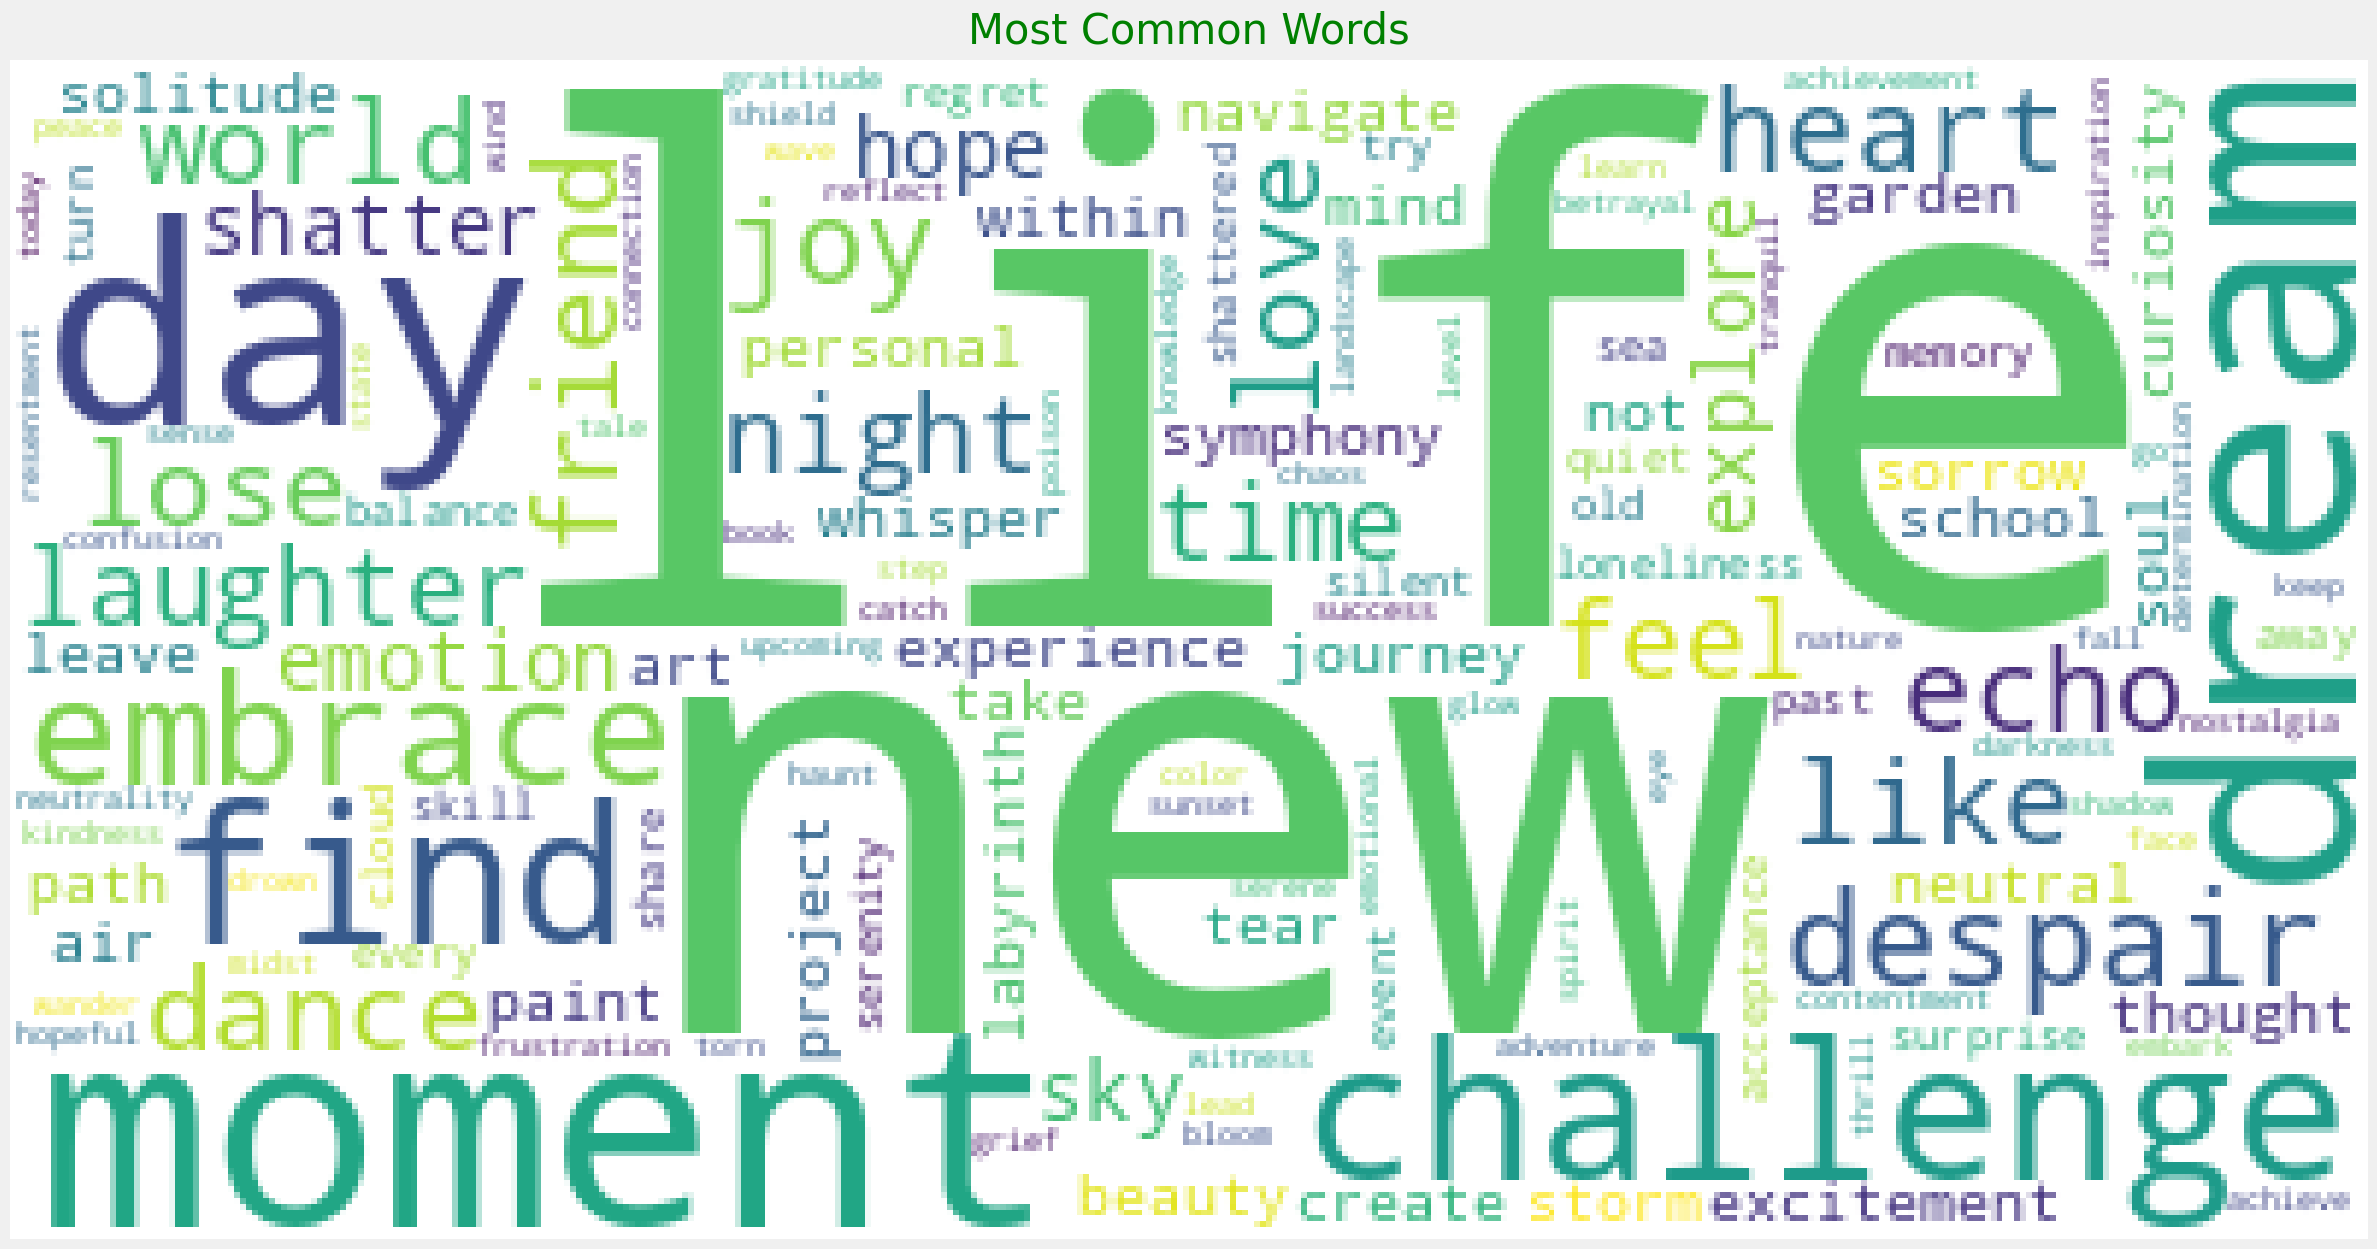

In [26]:
def plot_wordcloud(text, mask, title, title_size, figure_size=(24.0, 16.0), image_color=False):
    """ A function for creating wordcloud images """
    words = text
    allwords = []
    for wordlist in words:
        allwords += wordlist
    mostcommon = FreqDist(allwords).most_common(140)
    wordcloud = WordCloud(
                    background_color='white',
                    stopwords=stop_words,
                    max_words=140,
                    max_font_size=120,
                    random_state=42,
                    mask=mask,
                    collocations=False
    ).generate_from_frequencies(dict(mostcommon))

    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask)
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
    else:
        plt.imshow(wordcloud)
    plt.title(title, fontdict={'size': title_size, 'color': 'green', 'verticalalignment': 'bottom'})
    plt.axis('off')
    plt.tight_layout()
    plt.show()

plot_wordcloud(df['lemmatized'], None, 'Most Common Words', title_size=30)

The above code generates a word cloud visualization based on the lemmatized text data in the dataset. Word clouds are useful for visually representing the most frequent words in a corpus of text

The word cloud analysis provides a simple yet effective way to explore and understand the textual content of the dataset.

This step visually represents the most common words in the lemmatized text data. It provides an intuitive understanding of the prominent words in the dataset.

**STEP - 4 : Word2Vec Analysis**

Step - 4.1 : Corpus Creation

In [27]:
%%time
corpus = df['lemmatized'].tolist()

CPU times: user 75 µs, sys: 11 µs, total: 86 µs
Wall time: 89.2 µs


Step - 4.2 : Word2Vec Model Creation

In [28]:
W2V_SIZE = 300  # Dimensionality of the word vectors
W2V_WINDOW = 5   # Context window size
W2V_MIN_COUNT = 1  # Minimum frequency count of words

w2v_model = gensim.models.Word2Vec(corpus, vector_size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT)

Step - 4.3 : Vocab Creation

In [29]:
w2v_model.build_vocab(corpus)

In [30]:
words = w2v_model.wv.key_to_index.keys()

vocab_size = len(words)
print("Vocabulary size:", vocab_size)

Vocabulary size: 1870


Step - 4.4 : Training Word2Vec Model

In [31]:
w2v_model.train(corpus, total_examples=len(corpus), epochs=W2V_EPOCH)

(153645, 160352)

Step - 4.5 : Word2Vec Model Testing

In [32]:
# Find the most similar words to a given word
similar_words = w2v_model.wv.most_similar("joy")
print("Most similar words to 'joy':\n", similar_words)

Most similar words to 'joy':
 [('like', 0.9998088479042053), ('leave', 0.9997736811637878), ('dance', 0.9997674822807312), ('moment', 0.9997617602348328), ('laughter', 0.9997609853744507), ('friend', 0.9997604489326477), ('life', 0.9997550845146179), ('new', 0.9997522830963135), ('day', 0.9997519850730896), ('challenge', 0.9997493624687195)]


Word2Vec model is created to represent words in vector space. The vocabulary size is 1870, and the word vectors have a dimensionality of 300.

**STEP 5 : Sentiment Analysis using Deep-Learning Model**

# **Long Short-term Memory (LSTM)**

Long short-term memory (LSTM) is an artificial recurrent neural network architecture used in the field of deep learning. Unlike standard feedforward neural networks, LSTM has feedback connections. It never keeps the entire data like standard recurrent neural network, lstm keeps short-term memory of data.

Step - 5.1 : Token and Vocab Creation

In [33]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts(df_train['lemma_str'])

vocab_size = len(tokenizer.word_index) + 1
print("Total words:", vocab_size)

Total words: 1651


In [34]:
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train['lemma_str']), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test['lemma_str']), maxlen=SEQUENCE_LENGTH)

Step - 5.2 : Label Encoding

In [35]:
labels = df_train['Sentiment'].unique().tolist()
print(labels)

[1, 0, 2]


'0' represents Positive sentiments

'1' represents Negative sentiments

'2' represents Neutral sentiments

In [36]:
encoder = LabelEncoder()

encoder.fit(df_train['Sentiment'].tolist())
y_train = encoder.transform(df_train['Sentiment'].tolist()).reshape(-1, 1)
y_test = encoder.transform(df_test['Sentiment'].tolist()).reshape(-1, 1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (597, 1)
y_test shape: (150, 1)


In [37]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (597, 300)
y_train (597, 1)

x_test (150, 300)
y_test (150, 1)


In [38]:
y_train[:10]

array([[1],
       [0],
       [1],
       [2],
       [1],
       [0],
       [2],
       [0],
       [2],
       [0]])

Step - 5.3 : Embedding Layer Creation

In [39]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))

for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

print("Shape of embedding matrix:", embedding_matrix.shape)

Shape of embedding matrix: (1651, 300)


In [40]:
embedding_layer = Embedding(input_dim=vocab_size,
                             output_dim=W2V_SIZE,
                             weights=[embedding_matrix],
                             input_length=SEQUENCE_LENGTH,
                             trainable=False)

print(embedding_layer)

Step - 5.4 : Model Creation - LSTM

In [41]:
# Define the LSTM model
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          495300    
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 655801 (2.50 MB)
Trainable params: 160501 (626.96 KB)
Non-trainable params: 495300 (1.89 MB)
_________________________________________________________________


Step - 5.5 : Compiling Model

In [42]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Step - 5.6 : Callback Creation

In [43]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
    EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)
]

Step - 5.7 : Model Training

In [44]:
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
1/1 [==============================] - 17s 17s/step - loss: 0.6951 - accuracy: 0.4264 - val_loss: 0.6706 - val_accuracy: 0.3500 - lr: 0.0010
Epoch 2/8
1/1 [==============================] - 7s 7s/step - loss: 0.6583 - accuracy: 0.3389 - val_loss: 0.6592 - val_accuracy: 0.3500 - lr: 0.0010
Epoch 3/8
1/1 [==============================] - 6s 6s/step - loss: 0.6340 - accuracy: 0.3389 - val_loss: 0.6576 - val_accuracy: 0.3500 - lr: 0.0010
Epoch 4/8
1/1 [==============================] - 6s 6s/step - loss: 0.6197 - accuracy: 0.3389 - val_loss: 0.6592 - val_accuracy: 0.3500 - lr: 0.0010
Epoch 5/8
1/1 [==============================] - 6s 6s/step - loss: 0.6085 - accuracy: 0.3389 - val_loss: 0.6591 - val_accuracy: 0.3500 - lr: 0.0010
Epoch 6/8
1/1 [==============================] - 6s 6s/step - loss: 0.5975 - accuracy: 0.3389 - val_loss: 0.6553 - val_accuracy: 0.3500 - lr: 0.0010


An LSTM model is built for sentiment analysis, consisting of an embedding layer, LSTM layer, dropout layer, and dense layer.

Step - 5.8 : Model Evaluation

In [45]:
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:", score[1])
print("LOSS:", score[0])

1/1 [==============================] - 0s 433ms/step - loss: 0.6874 - accuracy: 0.3400

ACCURACY: 0.3400000035762787
LOSS: 0.687436044216156


The model is trained and evaluated. The accuracy achieved on the test set is **34%**

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

Accuracy Graph

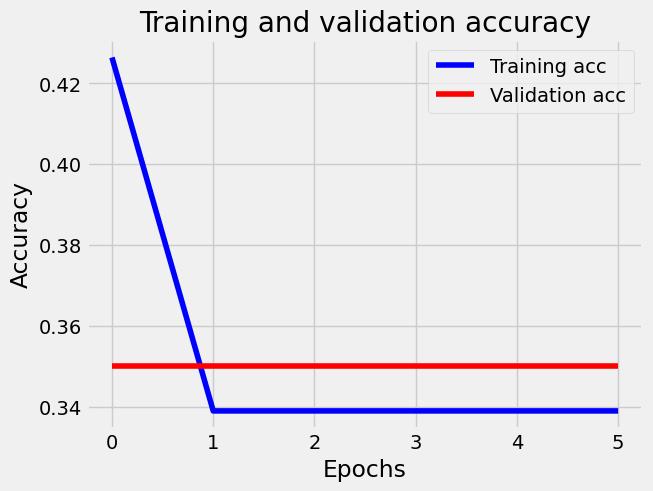

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [47]:
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure()

Loss graph

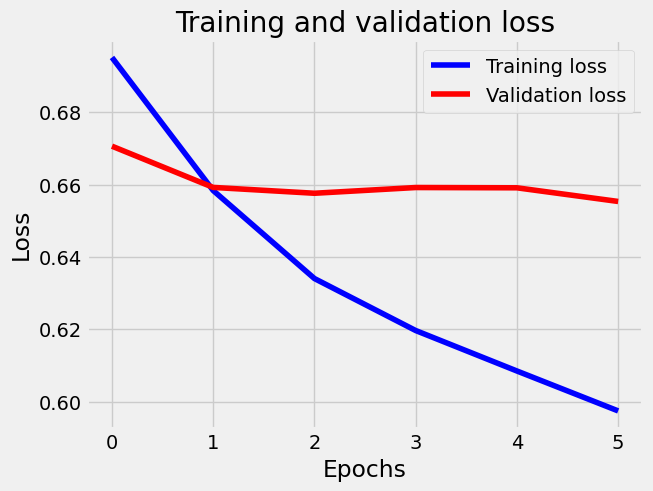

In [48]:
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Step - 5.9 : Prediction using Model

In [49]:
def decode_sentiment(score, include_neutral=True):
    label = NEUTRAL if include_neutral else NEGATIVE
    if score <= SENTIMENT_THRESHOLDS[0]:
        label = NEGATIVE
    elif score >= SENTIMENT_THRESHOLDS[1]:
        label = POSITIVE
    return label

In [50]:
def predict_sentiment(text, include_neutral=True):
    # Tokenize the text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict sentiment
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)
    return {"label": label, "score": float(score)}

In [51]:
print(predict_sentiment("I hate this product. It's terrible,useless"))

1/1 [==============================] - 1s 1s/step
{'label': '2', 'score': 0.5590533018112183}


Neutral

In [52]:
print(predict_sentiment("Experience has been bad"))

1/1 [==============================] - 0s 65ms/step
{'label': '2', 'score': 0.7177295684814453}


Neutral

In [56]:
print(predict_sentiment("I don't like to waste my time rather I like to do coding in my mean time"))

1/1 [==============================] - 0s 172ms/step
{'label': '0', 'score': 0.8823938965797424}


Positive

Step - 5.10 : Creating Confusion Matrix

In [60]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.Sentiment)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

1/1 [==============================] - 1s 1s/step
CPU times: user 1.27 s, sys: 38.6 ms, total: 1.31 s
Wall time: 1.37 s


In [61]:
# Convert numerical labels to strings
y_test_1d_str = [str(label) for label in y_test_1d]
y_pred_1d_str = [str(label) for label in y_pred_1d]

In [62]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

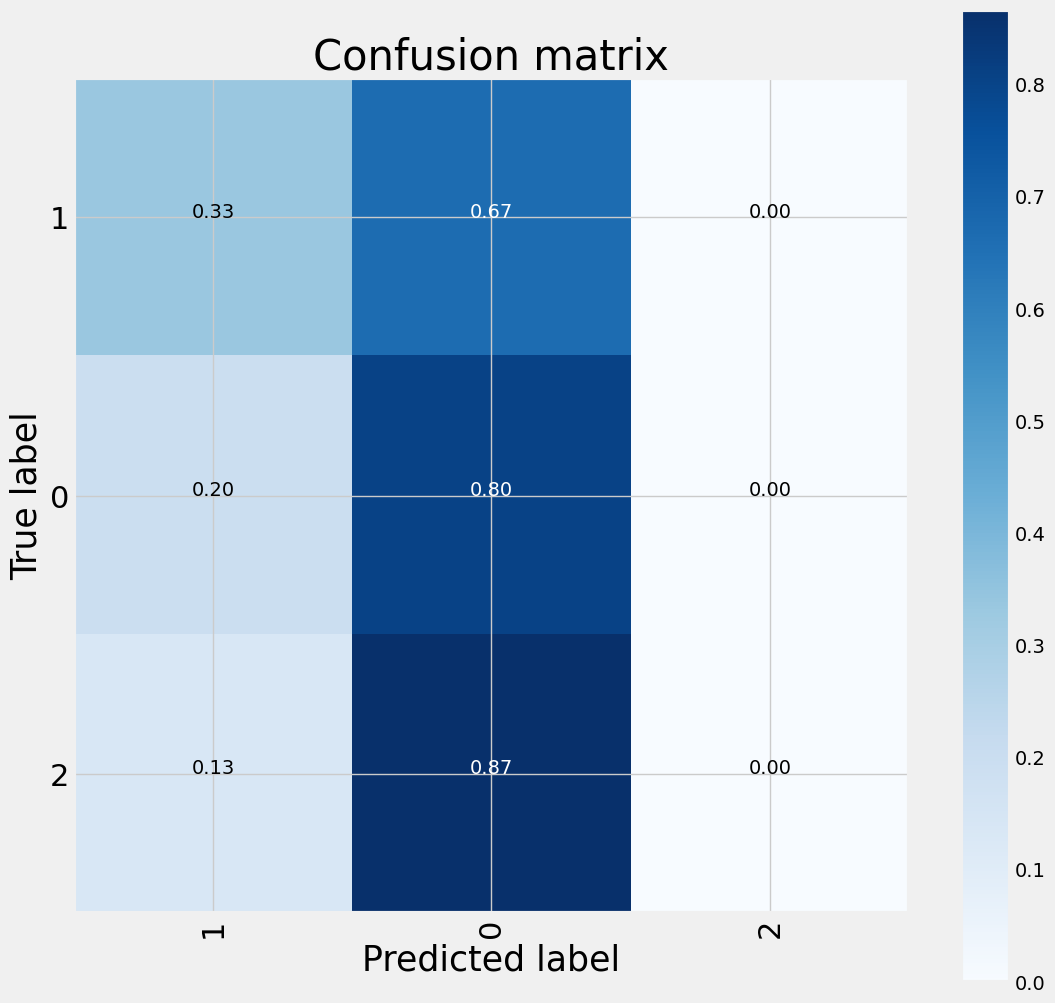

In [63]:
# Calculate confusion matrix
cnf_matrix = confusion_matrix(y_test_1d_str, y_pred_1d_str)

plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.Sentiment.unique(), title="Confusion matrix")
plt.show()

A confusion matrix is generated to evaluate the performance of the sentiment classification.

Step - 5.11 : Classification Report

In [64]:
report = classification_report(y_test_1d_str, y_pred_1d_str)

print(report)

              precision    recall  f1-score   support

           0       0.62      0.33      0.43        69
           1       0.36      0.80      0.50        51
           2       0.00      0.00      0.00        30

    accuracy                           0.43       150
   macro avg       0.33      0.38      0.31       150
weighted avg       0.41      0.43      0.37       150



The classification report provides precision, recall, F1-score, and support for each sentiment class.

Step - 5.12 : Accuracy Score

In [65]:
accuracy_LSTM = accuracy_score(y_test_1d_str, y_pred_1d_str)
print("Accuracy:", accuracy_LSTM)

Accuracy: 0.4266666666666667


The overall accuracy score is calculated, which is **42.67%**.

**STEP 5: Sentiments analysis using Machine learning algorithms**

# **Support Vector Machine (SVM)**

SVM is a supervised learning algorithm used for classification and regression tasks.

It works by finding the hyperplane that best separates different classes in the feature space.

SVM can handle both linear and non-linear data separation through the use of different kernel functions such as linear, polynomial, and radial basis function (RBF).

SVM aims to maximize the margin between classes, which helps in achieving better generalization performance.

Step - 5.1 : Token and Vocab Creation

In [66]:
from sklearn.feature_extraction.text import TfidfVectorizer

tokenizer = TfidfVectorizer()

tokenizer.fit(df_train['lemma_str'])

vocab_size = len(tokenizer.vocabulary_) + 1
print("Total words:", vocab_size)

Total words: 1650


In SVM, instead of using a tokenizer like in deep learning models, we often use techniques like TF-IDF (Term Frequency-Inverse Document Frequency) to convert text into numerical vectors. TfidfVectorizer is a scikit-learn class that can be used to perform this transformation. It tokenizes the text and computes the TF-IDF scores for each word.

The TF-IDF vectorization technique was used to convert text data into numerical vectors. Each word was assigned a TF-IDF score, resulting in a vocabulary size of 1650 unique words.

Step - 5.2 : Label Encoding

In [67]:
y_train = df_train['Sentiment'].values
y_test = df_test['Sentiment'].values

print("y_train", y_train.shape)
print("y_test", y_test.shape)

y_train (597,)
y_test (150,)


In [68]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (597, 300)
y_train (597,)

x_test (150, 300)
y_test (150,)


In [69]:
y_train[:10]

array([1, 0, 1, 2, 1, 0, 2, 0, 2, 0])

Embedding layers are specific to neural network-based models like LSTM, but SVM operates on a different principle and doesn't require embedding layers.

Step - 5.3 : Model Creation - SVM

In [71]:
from sklearn.svm import SVC

svm_classifier = SVC(kernel='linear')

Step - 5.4: Model Training

In [72]:
svm_classifier.fit(x_train, y_train)

SVC(kernel='linear')

Step - 5.4: Model Evaluation

In [73]:
accuracy_1 = svm_classifier.score(x_test, y_test)
print("Accuracy:", accuracy_1)

Accuracy: 0.3933333333333333


The accuracy of the SVM classifier on the test data was found to be approximately **39.33%.**

Step - 5.5: Prediction using Model

In [74]:
y_pred = svm_classifier.predict(x_test)
print(y_pred)

[0 0 1 2 0 1 2 0 1 0 1 1 1 2 2 2 2 1 1 2 2 2 0 2 2 1 1 0 2 0 1 0 2 0 1 2 2
 1 1 1 1 0 2 2 0 0 0 2 2 2 0 1 0 1 0 0 1 2 1 2 2 0 1 2 1 1 0 1 0 0 2 1 0 0
 2 1 0 2 0 2 2 0 1 0 0 2 2 1 1 1 1 2 2 0 0 2 2 1 1 2 2 2 1 1 2 0 2 2 2 1 2
 2 2 2 1 0 2 2 1 0 0 2 1 2 1 0 2 0 1 1 2 2 2 0 1 1 1 1 0 1 2 0 2 2 2 2 0 2
 0 1]


Step - 5.6: Creating Confusion Matrix

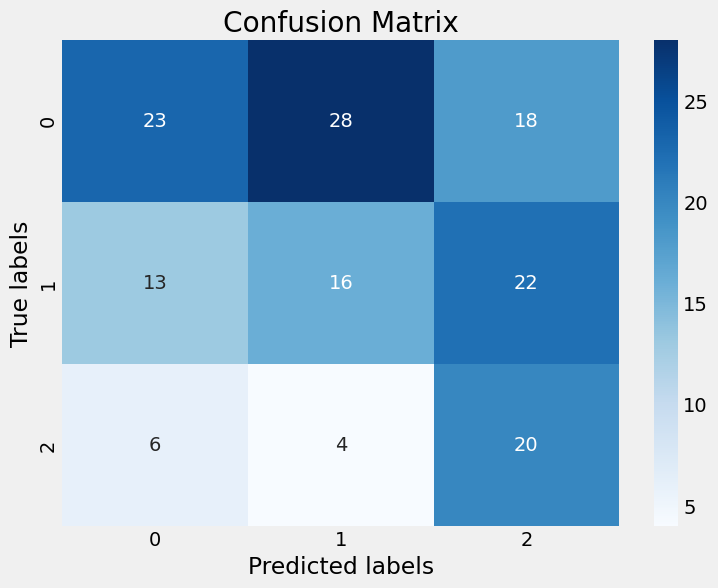

In [75]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Step - 5.7: Classification Report

In [76]:
from sklearn.metrics import classification_report

class_report = classification_report(y_test, y_pred)

print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.33      0.41        69
           1       0.33      0.31      0.32        51
           2       0.33      0.67      0.44        30

    accuracy                           0.39       150
   macro avg       0.40      0.44      0.39       150
weighted avg       0.43      0.39      0.39       150



Step - 5.8: Accuracy Score

In [78]:
from sklearn.metrics import accuracy_score

accuracy_SVM = accuracy_score(y_test, y_pred)
print("Accuracy Score:", accuracy_SVM)

Accuracy Score: 0.3933333333333333


The accuracy score of the SVM classifier on the test data was approximately **39.33%.**

# **Random Forest**

Random Forest is an ensemble learning method used for classification and regression tasks.

It constructs multiple decision trees during training and outputs the mode of the classes (for classification) or the mean prediction (for regression) of the individual trees.

Random Forest introduces randomness in the tree-building process by selecting a random subset of features for each tree and using bootstrapped samples from the training data.

It reduces overfitting and improves generalization performance by averaging predictions from multiple trees.

Step - 5.1 : Token and Vocab Creation

In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer

tokenizer = TfidfVectorizer()

tokenizer.fit(df_train['lemma_str'])

vocab_size = len(tokenizer.vocabulary_) + 1
print("Total words:", vocab_size)

Total words: 1650


Step - 5.2: Label Encoding

In [80]:
y_train_RF = df_train['Sentiment'].values
y_test_RF = df_test['Sentiment'].values

print("y_train", y_train_RF.shape)
print("y_test", y_test_RF.shape)

y_train (597,)
y_test (150,)


In [81]:
print("x_train", x_train.shape)
print("y_train", y_train_RF.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test_RF.shape)

x_train (597, 300)
y_train (597,)

x_test (150, 300)
y_test (150,)


In [82]:
y_train_RF[:10]

array([1, 0, 1, 2, 1, 0, 2, 0, 2, 0])

Step - 5.3: Model Creation

In [83]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

A Random Forest classifier was initialized with 100 decision trees. Random Forest is an ensemble learning method that builds multiple decision trees during training and outputs the mode of the classes predicted by the individual trees.

Step - 5.4: Model Training

In [84]:
rf_classifier.fit(x_train, y_train_RF)

RandomForestClassifier(random_state=42)

Step - 5.5: Model Evaluation

In [85]:
accuracy_2 = rf_classifier.score(x_test, y_test_RF)
print("Accuracy:", accuracy_2)

Accuracy: 0.5666666666666667


Step - 5.6: Prediction using Model

In [86]:
y_pred = rf_classifier.predict(x_test)
print(y_pred)

[0 0 1 0 0 0 1 0 1 0 1 1 1 2 0 0 2 0 1 2 2 2 0 2 2 0 0 0 2 0 1 0 1 0 1 2 2
 1 1 1 1 1 2 2 0 0 0 1 2 1 0 1 0 2 1 1 0 0 1 2 2 0 0 2 0 0 0 0 0 0 1 1 0 0
 2 0 0 2 1 1 2 0 1 0 0 1 2 0 1 1 1 2 2 0 0 1 1 1 0 2 2 0 0 2 2 1 2 1 2 1 1
 2 0 1 0 1 2 2 0 0 1 1 1 2 1 0 2 0 0 1 2 2 2 0 0 1 1 1 0 1 1 0 1 2 2 2 0 2
 1 1]


Step - 5.7: Creating Confusion Matrix

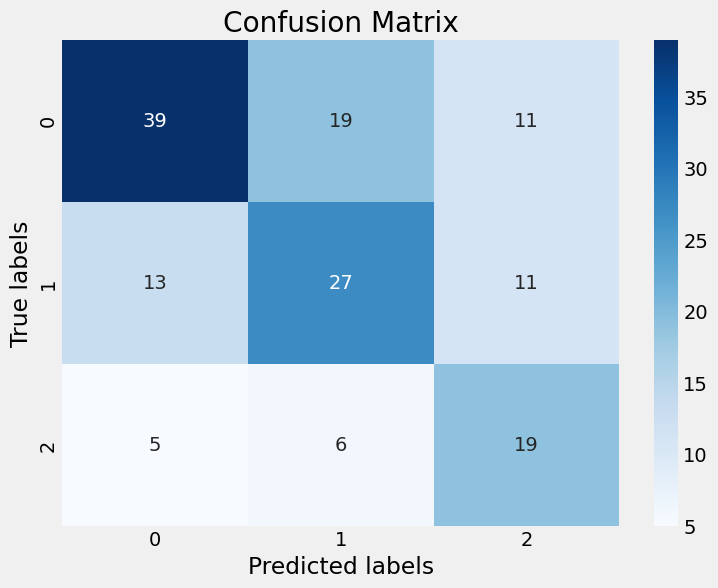

In [87]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_test_RF, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Step - 5.8: Classification Report

In [88]:
from sklearn.metrics import classification_report

class_report = classification_report(y_test_RF, y_pred)

print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.57      0.62        69
           1       0.52      0.53      0.52        51
           2       0.46      0.63      0.54        30

    accuracy                           0.57       150
   macro avg       0.56      0.58      0.56       150
weighted avg       0.58      0.57      0.57       150



Step - 5.9: Accuracy Score

In [89]:
from sklearn.metrics import accuracy_score

accuracy_RF = accuracy_score(y_test_RF, y_pred)
print("Accuracy Score:", accuracy_RF)

Accuracy Score: 0.5666666666666667


the Random Forest model achieved an accuracy of approximately **56.7%**, indicating moderate performance in sentiment classification on the given dataset.

# **COMPARISON**

**1. Accuracy:**

LSTM: Achieved an accuracy of approximately 42.67%.

SVM: Achieved an accuracy of approximately 39.3%.

Random Forest: Achieved an accuracy of approximately 56.7%.

**2. Performance Metrics:**

LSTM: Demonstrated moderate accuracy and performance metrics, falling between
SVM and Random Forest.

SVM: Showed relatively lower accuracy compared to LSTM and Random Forest. Precision, recall, and F1-score across all classes were also relatively lower.

Random Forest: Outperformed both LSTM and SVM in terms of accuracy and performance metrics, indicating its ability to capture complex patterns in the data.

**3. Complexity and Interpretability:**

LSTM: Deep learning models like LSTM are complex and computationally intensive. Interpretability might be challenging due to their black-box nature.

SVM: Relatively simpler compared to deep learning models. SVM models offer good interpretability, making it easier to understand decision boundaries.

Random Forest: Falls between LSTM and SVM in terms of complexity. It's an ensemble learning method, providing a balance between interpretability and performance.

**4. Data Requirements:**

LSTM: Requires large amounts of data for training to perform well. Effective in capturing complex patterns but may suffer from overfitting.

SVM: Can work well with smaller datasets and is less prone to overfitting. Performs better when the number of features is not too high.

Random Forest: Can handle both small and large datasets effectively. It can also hold a large number of input variables without overfitting.

**5. Generalisation:**

LSTM: Has the potential to generalize well to unseen data if trained properly. Capable of capturing intricate patterns.

SVM: This may not generalize as well as deep learning models but can still perform reasonably well with proper hyperparameter tuning.

Random Forest: Tends to generalize well to unseen data due to its ensemble approach, which helps reduce overfitting.

**Best Model**

Overall, Random Forest emerged as the top-performing model among the three in terms of accuracy and generalization. It demonstrated better performance compared to both LSTM and SVM, indicating its suitability for sentiment analysis tasks, especially when dealing with relatively small datasets or complex patterns in the data.